First we have to download all requirements package to use anomalib

Import libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
from anomalib.metrics import AUROC
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.models import Patchcore, EfficientAd
from anomalib.utils.visualization import ImageResult
from anomalib.data.utils import read_image

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

Data downloading

In [2]:
categories = ["tile", "leather", "grid"]
datamodules = {cat: MVTec(category=cat, num_workers=0) for cat in categories}

In [3]:
for cat, datamodule in datamodules.items():
    datamodule.prepare_data()
    datamodule.setup()
i, data = next(enumerate(datamodules["tile"].val_dataloader()))

INFO:anomalib.data.image.mvtec:Found the dataset.
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO:anomalib.data.image.mvtec:Found the dataset.


intialize models

In [4]:
patchcore_model = Patchcore(pre_trained=True)

INFO:anomalib.models.components.base.anomaly_module:Initializing Patchcore model.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/wide_resnet50_2.racm_in1k)
INFO:timm.models._hub:[timm/wide_resnet50_2.racm_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [5]:
efficientad_model = EfficientAd()

INFO:anomalib.models.components.base.anomaly_module:Initializing EfficientAd model.


It is recommend that you have gpu to train the model or else it will take forever.

In [6]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

CUDA Available: True
Number of GPUs: 1


Training

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize engine

auroc_results = {}
y_label = {}
y_score = {}
for model_name, model in [("Patchcore", patchcore_model)]:
    auroc_results[model_name] = {}
    for cat, datamodule in datamodules.items():
        y_label[cat] = []
        y_score[cat] = []
        print(f"Training {model_name} for {cat}")
        engine = Engine(
            devices=1,  # Number of GPUs to use
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            max_epochs=3,
            # val_check_interval=1.0,  # Enable validation after every epoch
        )
        engine.fit(model=model, datamodule=datamodule)

        print(f"Evaluating {model_name} for {cat}")

        test_results = engine.test(
            model=model,
            datamodule=datamodule,
            ckpt_path=f"./results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )

        # Extract AUROC Score
        auroc_score = test_results[0]["image_AUROC"]
        auroc_results[model_name][cat] = auroc_score
        predictions = engine.predict(
            datamodule=datamodule,
            model=model,
            ckpt_path=f"./results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )


        for batch in predictions:
          y_label[cat].extend(batch['label'].numpy())
          y_score[cat].extend(batch['pred_scores'].numpy())
        print(f"{model_name} AUROC for {cat}: {auroc_score:.4f}")

INFO:anomalib.engine.engine:Overriding max_epochs from 3 with 1 for Patchcore
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tqn/.conda/envs/env/lib/python3.10/site-packag ...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training Patchcore for tile


INFO: You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tqn/.conda/envs/env/lib/python3.10/site-

/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.patchcore.lightning_model:Aggregating the embedding extracted from the training set.
INFO:anomalib.models.image.patchcore.lightning_model:Applying core-set subsampling to get the embedding.
















































































































































Selecting Coreset Indices.: 100%|██████████| 18032/18032 [00:14<00:00, 1239.57it/s]
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 34.68 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/ass

Evaluating Patchcore for tile


INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 27.114582061767578 seconds
Throughput (batch_size=32) : 4.3150213318232815 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9877344965934753     │
│       image_F1Score       │    0.9818181991577148     │
│        pixel_AUROC        │    0.9471516609191895     │
│       pixel_F1Score       │    0.6195613741874695     │
└───────────────────────────┴───────────────────────────┘

INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/tile/v1/weights/lightning/model.ckpt
/home/tqn/.conda/envs/env/lib/python3.10/site-p

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.engine.engine:Overriding max_epochs from 3 with 1 for Patchcore
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tqn/.conda/envs/env/lib/python3.10/site-packag ...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tqn/.conda/en

Patchcore AUROC for tile: 0.9877
Training Patchcore for leather


/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 21.60 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loade

Evaluating Patchcore for leather


/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 30.33109164237976 seconds
Throughput (batch_size=32) : 4.0882142147083975 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7591711282730103     │
│       image_F1Score       │    0.8465116024017334     │
│        pixel_AUROC        │    0.9085433483123779     │
│       pixel_F1Score       │    0.2996700406074524     │
└───────────────────────────┴───────────────────────────┘

INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/leather/v1/weights/lightning/model.ckpt
/home/tqn/.conda/envs/env/lib/pytho

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.engine.engine:Overriding max_epochs from 3 with 1 for Patchcore
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tqn/.conda/envs/env/lib/python3.10/site-packag ...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tqn/.conda/en

Patchcore AUROC for leather: 0.7592
Training Patchcore for grid


/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 13.26 seconds
INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model w

Evaluating Patchcore for grid


/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 15.912167310714722 seconds
Throughput (batch_size=32) : 4.901909241959604 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.7928153872489929     │
│       image_F1Score       │     0.852173924446106     │
│        pixel_AUROC        │    0.26558512449264526    │
│       pixel_F1Score       │   0.016550768166780472    │
└───────────────────────────┴───────────────────────────┘

INFO:anomalib.data.image.mvtec:Found the dataset.
INFO: Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /mmfs1/project/phan/tqn/eng-ai-agents/assignments/assignment-2/results/Patchcore/MVTec/grid/v1/weights/lightning/model.ckpt
/home/tqn/.conda/envs/env/lib/python3.10/site-p

Predicting: |          | 0/? [00:00<?, ?it/s]

Patchcore AUROC for grid: 0.7928


In [8]:
average_auroc = np.mean([auroc_results['Patchcore']['tile'], auroc_results['Patchcore']['leather'], auroc_results['Patchcore']['grid']])
print(f"average Area under the curve: {average_auroc}")

average Area under the curve: 0.8465736707051595


We train model on 3 categories (Title, leather, Grid)
In the process of training you will see Coreset Indices Selecting. This process is the greedy coreset subsampling method that model will select a subset of important features as reference for anomaly detection.

We can see model work best when detecting tile then grid and finally leather

In [9]:
categories = ["tile", "leather", "grid"]
datamodules = {cat: MVTec(category=cat, num_workers=0, train_batch_size=1) for cat in categories}

In [10]:
from torchvision import datasets
import os

dataset_path = 'datasets/imagenette'

# Manually extract if needed
if not os.path.exists(dataset_path):
    print(f"Dataset path {dataset_path} not found, extracting the dataset...")
    # Assuming you're manually extracting the .tgz
    os.system(f"tar -xvzf {dataset_path}.tgz -C datasets/")


In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Initialize engine

auroc_results = {}
y_label = {}
y_score = {}
for model_name, model in [("EfficientAd", efficientad_model)]:
    auroc_results[model_name] = {}
    for cat, datamodule in datamodules.items():
        y_label[cat] = []
        y_score[cat] = []
        print(f"Training {model_name} for {cat}")
        engine = Engine(
            devices=1,  # Number of GPUs to use
            accelerator="gpu" if torch.cuda.is_available() else "cpu",
            max_epochs=3,
            # val_check_interval=1.0,  # Enable validation after every epoch
        )
        engine.fit(model=model, datamodule=datamodule)

        print(f"Evaluating {model_name} for {cat}")

        test_results = engine.test(
            model=model,
            datamodule=datamodule,
            ckpt_path=f"./results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )

        # Extract AUROC Score
        auroc_score = test_results[0]["image_AUROC"]
        auroc_results[model_name][cat] = auroc_score
        predictions = engine.predict(
            datamodule=datamodule,
            model=model,
            ckpt_path=f"./results/{model_name}/MVTec/{cat}/latest/weights/lightning/model.ckpt"
        )


        for batch in predictions:
          y_label[cat].extend(batch['label'].numpy())
          y_score[cat].extend(batch['pred_scores'].numpy())
        print(f"{model_name} AUROC for {cat}: {auroc_score:.4f}")

/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tqn/.conda/envs/env/lib/python3.10/site-packag ...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:anomalib.data.image.mvtec:Found the dataset.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | model                 | EfficientAdModel         | 8.1 M  | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | train
3 | image_threshold       | F1AdaptiveThreshold      | 0      | train
4 | pixel_threshold       | F1AdaptiveThreshold      | 0      | train
5 | image_metrics         | AnomalibMetricCollection | 0      | train
6 | pixel_metrics         | AnomalibMetricCollection | 0      | train
---------------------------------------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
32.235    Total estimated model params size (MB)
INFO:lightning.pytor

Training EfficientAd for tile


/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.
/home/tqn/.conda/envs/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=16` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.models.image.efficient_ad.lightning_model:Load pretrained teacher model from pre_trained/efficientad_pretrained_weights/pretrained_teacher_small.pth
/mmfs1/project/phan/tqn/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


FileNotFoundError: Couldn't find any class folder in datasets/imagenette.

In [ ]:
import os
print(os.listdir("datasets/imagenette"))

['imagenette2.tgz']


EfficientAd using nearly the same technique as PatchCore with some updates, first they using imagenet pretrained model and use distlation method to finetune and have a better model. This method is more lightweight compare to PatchCore

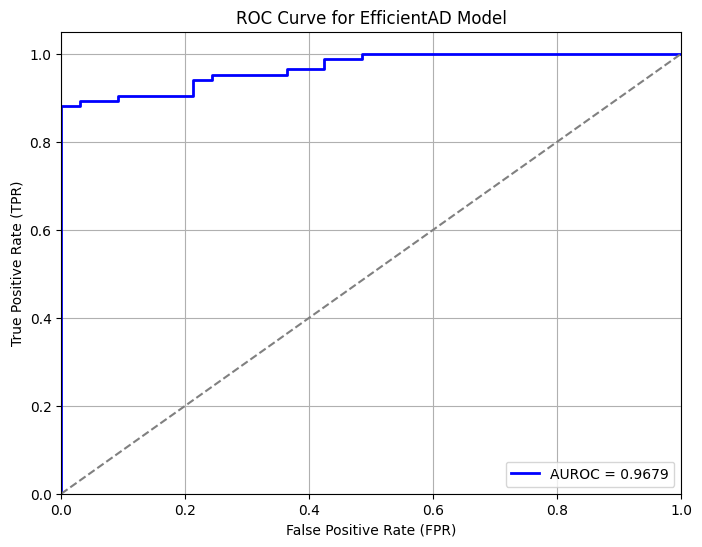

<Figure size 640x480 with 0 Axes>

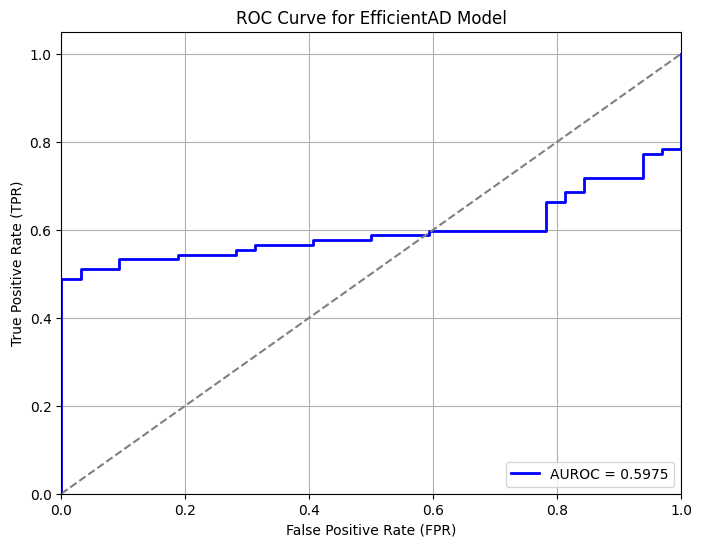

<Figure size 640x480 with 0 Axes>

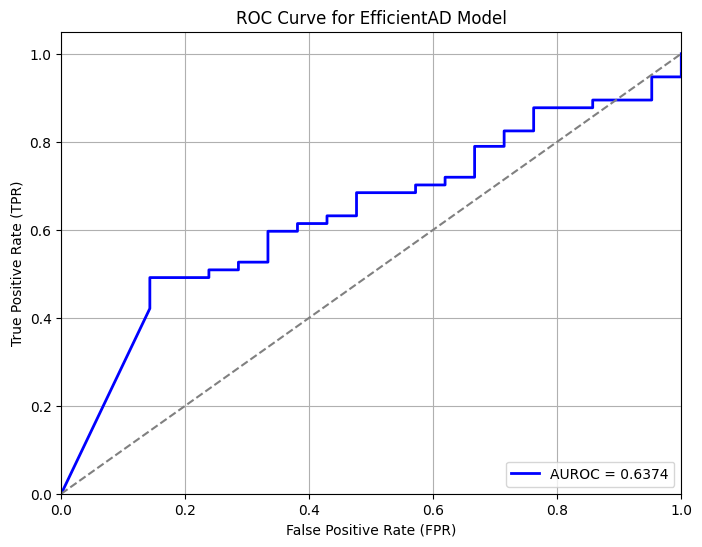

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for cat in categories:
  y_true_tensor = torch.tensor(y_label[cat])
  y_scores_tensor = torch.tensor(y_score[cat])
  auroc_score = AUROC()(y_scores_tensor, y_true_tensor)
  fpr, tpr, _ = roc_curve(y_label[cat], y_score[cat])
  roc_auc = auc(fpr, tpr)
  # Plot ROC Curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUROC = {roc_auc:.4f}")
  plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random chance line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate (FPR)")
  plt.ylabel("True Positive Rate (TPR)")
  plt.title("ROC Curve for EfficientAD Model")
  plt.legend(loc="lower right")
  plt.grid()
  plt.show()
  plt.clf()

You can see that the performance of EfficientAd on these three categories is lower than PatchCore

In [ ]:
for model_name in auroc_results.keys():
    avg_auroc = sum(auroc_results[model_name].values()) / len(auroc_results[model_name])
    auroc_results[model_name]["Average"] = avg_auroc
    print(f"{model_name} Average AUROC: {avg_auroc:.4f}")

EfficientAd Average AUROC: 0.7343


In [ ]:
def show_image_and_mask(sample, index):
    """Show an image with a mask."""
    image = Image.open(sample.image_path[index])
    mask = ToPILImage()(sample.gt_mask[index].int()).convert("RGB")

    if image.size != mask.size:
        mask = mask.resize(image.size)

    return Image.fromarray(np.hstack((np.array(image), np.array(mask))))

# Visualize a sample from tile dataset
show_image_and_mask(data, index=0)

AttributeError: 'dict' object has no attribute 'image_path'